# Evaluating the Model

### Install Requirements

In [1]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn

### Import Required Libraries

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms

### Specify Model

There are several output folders from training multiple models.  

In [3]:
# set this to today's date
today = "2023-05-09"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder = today + "_" + suffix

k = 2

In [4]:
dataset = fo.Dataset.from_dir(
    data_path="/home/jovyan/work/data/",
    labels_path=f"/home/jovyan/work/{output_folder}/test_{k}.json",
    dataset_type=fo.types.COCODetectionDataset, 
    name=f"test_{today}_{k}",
    label_types="segmentations"
)


 100% |███████████████████| 35/35 [7.5s elapsed, 0s remaining, 5.1 samples/s]      


In [5]:
print(dataset)

Name:        test_2023-05-09_2
Media type:  image
Num samples: 35
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [6]:
base_path = f"/home/jovyan/work/{output_folder}/fold_{k}/"

leaf_cfg = get_cfg()
leaf_cfg.MODEL.DEVICE='cpu'
leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

leaf_predictor = DefaultPredictor(leaf_cfg)

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

[03/06 19:21:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/2023-05-09_kfold_train/fold_2/model_final.pth ...


namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [7]:
from IPython.display import display


In [8]:


with fo.ProgressBar() as pb:
    for sample in pb(dataset):

        # run interence on selected image
        image = Image.open(sample.filepath)
        image = ImageOps.exif_transpose(image)
        
        image_arr = np.array(image)
        h, w, c = image_arr.shape
        print (h,w,c)
        outputs = leaf_predictor(image_arr)
        
        # get bboxes and class labels
        pred_boxes = outputs["instances"].pred_boxes.tensor.numpy()
        pred_masks = outputs["instances"].pred_masks.numpy()
        class_labels = outputs["instances"].pred_classes.numpy()
        scores = outputs["instances"].scores.numpy()
        
        # track indicies of 
        qr_indices = []
        leaf_indices = []
        red_square_indices = []
        
        # get indices of leaves and qr codes
        for i, label in enumerate(class_labels):
            if label == 0: # leaf
                leaf_indices.append(i)
            elif label == 1: # qr
                qr_indices.append(i)
            elif label == 2: # red-square
                red_square_indices.append(i)
                
        classes = ['leaf', 'qr', 'red-square']
        
        detections = []
        
        # track pixel 
        red_square_pixels = 0
        leaf_pixels = 0
        qr_pixels = 0
        
        for label, mask, box, score in zip(class_labels, pred_masks, pred_boxes, scores):
           
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
            
            bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
            mask_h, mask_w = bbox_mask.shape
            
            mask_pixel_count = np.count_nonzero(mask)
            class_label = classes[label]
            
            # print('label: ', class_label)
            # print('mask_pixel_count: ', mask_pixel_count)
            
            if class_label == 'leaf':
                leaf_pixels += mask_pixel_count
            elif class_label == 'red-square':
                red_square_pixels = mask_pixel_count
            elif class_label == 'qr':
                qr_pixels = mask_pixel_count

            
            
            # print(mask.shape)
            # print(np.count_nonzero(mask))
            
            # print(rel_box)
            
            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                )
            )
        
        
        print('image: ', sample.filepath)
        print('red_square_pixels: ', red_square_pixels)
        print('leaf_pixels: ', leaf_pixels)
        print('qr_pixels: ', qr_pixels)
        
        leaf_area = None
        
        if red_square_pixels:
            leaf_area = (4 * leaf_pixels) / red_square_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        elif qr_pixels:
            leaf_area = (1.44 * leaf_pixels) / qr_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        
        sample["predictions"] = fo.Detections(detections=detections)
        sample["height"] = h
        sample["width"] = w
        sample["area"] = leaf_area
        
        sample.save()


        

   0% ||------------------|  0/35 [10.2ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


4640 6960 3                                                                  
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5987.JPG
red_square_pixels:  1112281
leaf_pixels:  6892
qr_pixels:  354924
leaf area: 0.024785103764246624 cm2
4640 6960 3                                                                      
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5975.JPG
red_square_pixels:  1121903
leaf_pixels:  59625
qr_pixels:  314012
leaf area: 0.21258522349971432 cm2
4640 6960 3                                                                      
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5968.JPG
red_square_pixels:  1087265
leaf_pixels:  445856
qr_pixels:  267633
leaf area: 1.6402845672398174 cm2
4640 6960 3                                                                      
image:  /home/jovyan/work/data/leaves/new_batch/IMG_5962.JPG
red_square_pixels:  1068024
leaf_pixels:  1980029
qr_pixels:  277347
leaf area: 7.415672306989356 cm2
4640 6960 3             

In [9]:
print(dataset.last())
!pip install openpyxl

<Sample: {
    'id': '65e8c250cd946598a3b2caa7',
    'media_type': 'image',
    'filepath': '/home/jovyan/work/data/leaves/new_batch/IMG_5929.JPG',
    'tags': [],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 6960,
        'height': 4640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '65e8c24fcd946598a3b2caa3',
                'attributes': {},
                'tags': [],
                'label': 'qr',
                'bounding_box': [
                    0.7682316844429107,
                    0.31332662595280913,
                    0.10011441695968493,
                    0.11188167281398198,
                ],
                'mask': array([[False, False, False, ...,  True,  True, False],
                       [False, False, False, ...,  True,  True, False],
                       [False, False, False, ...,  True,  True, Fa

In [10]:
import pandas as pd

df = pd.read_excel('/home/jovyan/work/First_batch_area.xlsx')
df['ml_area'] = None
df['ml_area'] = df['ml_area'].astype(float)
print(df)


          picture  area_cm2  ml_area
0    IMG_5792.tif      0.16      NaN
1    IMG_5793.tif      0.07      NaN
2    IMG_5794.tif      0.37      NaN
3    IMG_5795.tif      0.09      NaN
4    IMG_5849.tif      0.66      NaN
..            ...       ...      ...
174  IMG_6055.tif      4.70      NaN
175  IMG_6056.tif     16.53      NaN
176  IMG_6057.tif      0.83      NaN
177  IMG_6058.tif      0.55      NaN
178  IMG_6059.tif      4.95      NaN

[179 rows x 3 columns]


In [11]:
missing = []

for sample in dataset:

    filename = sample.filepath.split('/')[-1].split('.')[0]
    print(filename)
    print(sample.area)
    
    if not df.loc[df['picture'].str.startswith(filename)].empty:
        df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
    else:
        missing.append(filename)

print(df)
print(missing)


    

IMG_5987
0.024785103764246624
IMG_5975
0.21258522349971432
IMG_5968
1.6402845672398174
IMG_5962
7.415672306989356
IMG_5868
0.0
IMG_5918
0.17296444077467812
IMG_5957
0.25164083279166993
IMG_5950
0.3701716757617716
IMG_6052
0.9832453679097191
IMG_6049
0.028808244743145122
IMG_6041
0.27682008567713634
IMG_6035
8.184532245730308
IMG_6034
0.7949016032281203
IMG_6029
0.23104145128421125
IMG_5976
1.6695551755852918
IMG_5863
0.5472498169528809
IMG_5862
0.4101257777327313
IMG_5860
0.2671892140225208
IMG_5920
0.09762090019840657
IMG_5919
0.0
IMG_6003
0.2790495867768595
IMG_6002
0.3531342634850263
IMG_6001
7.384644483313899
IMG_5995
3.6067676845023873
IMG_5993
0.12300702882012537
IMG_5992
0.34908821174670707
IMG_5940
0.3262516385547404
IMG_5915
0.25528524331382624
IMG_5977
0.032938492790004575
IMG_5912
0.4455286788872234
IMG_5972
0.40860335284768423
IMG_5971
2.7731957743046283
IMG_5853
1.1949817849220843
IMG_5795
0.10913221402072897
IMG_5929
0.16955112742527528
          picture  area_cm2  ml_are

In [12]:
df_area = df[df['ml_area'] >= 0.0]
print(df_area)
df.dtypes

          picture  area_cm2  ml_area
3    IMG_5795.tif      0.09     0.11
8    IMG_5853.tif      0.77     1.19
15   IMG_5860.tif      0.15     0.27
17   IMG_5862.tif      0.35     0.41
18   IMG_5863.tif      0.46     0.55
21   IMG_5868.tif      0.04     0.00
39   IMG_5912.tif      0.44     0.45
42   IMG_5915.tif      0.31     0.26
45   IMG_5918.tif      0.36     0.17
46   IMG_5919.tif      0.00     0.00
47   IMG_5920.tif      0.06     0.10
56   IMG_5929.tif      0.15     0.17
67   IMG_5940.tif      0.36     0.33
77   IMG_5950.tif      0.38     0.37
84   IMG_5957.tif      0.28     0.25
88   IMG_5962.tif      7.80     7.42
94   IMG_5968.tif      1.75     1.64
97   IMG_5971.tif      2.97     2.77
98   IMG_5972.tif      0.44     0.41
101  IMG_5975.tif      0.26     0.21
102  IMG_5976.tif      2.09     1.67
103  IMG_5977.tif      0.09     0.03
111  IMG_5987.tif      0.04     0.02
116  IMG_5992.tif      0.36     0.35
117  IMG_5993.tif      0.15     0.12
119  IMG_5995.tif      3.66     3.61
1

picture      object
area_cm2    float64
ml_area     float64
dtype: object

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


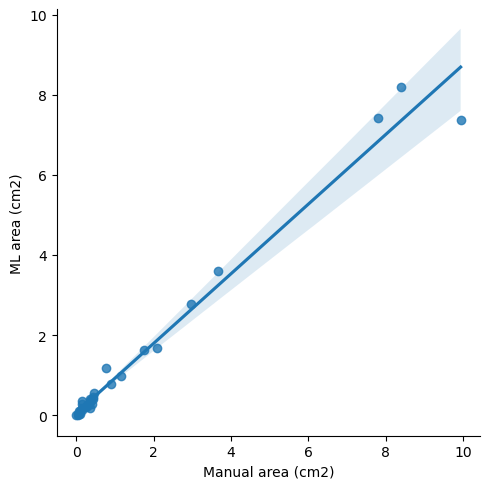

In [13]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual area (cm2)', ylabel='ML area (cm2)')

In [14]:
df_area.corr(numeric_only=True)

,area_cm2,ml_area
area_cm2,1.000000,0.989459
ml_area,0.989459,1.000000


In [15]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.9894590654940671, pvalue=2.8207413657609884e-29)
r^2: 0.9790292422883926


In [16]:
df_area.corr(method='pearson', numeric_only=True)

,area_cm2,ml_area
area_cm2,1.000000,0.989459
ml_area,0.989459,1.000000


In [17]:
df_area.corr(method='kendall', numeric_only=True)

,area_cm2,ml_area
area_cm2,1.000000,0.874482
ml_area,0.874482,1.000000


In [18]:
count = 0

for i in range(0, 1000):
    df_area_permutation = df_area.copy()
    
    # permute ml_area column
    # df_area_permutation['area_cm2'] = np.random.permutation(df_area_permutation['area_cm2'])
    df_area_permutation['ml_area'] = np.random.permutation(df_area_permutation['ml_area'])
    # print(df_area_permutation)
    
    # get r^2 value for permutation
    permutation_corr = stats.pearsonr(df_area_permutation.area_cm2, df_area_permutation.ml_area)
    permutation_r_squared = permutation_corr.statistic * permutation_corr.statistic
    # print(permutation_corr)
    # print(permutation_r_squared)
    
    if permutation_r_squared > r_squared:
        count += 1

print(count)
    
    
    
    
    
    

0


In [19]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")

Connected to FiftyOne on port 5151 at 0.0.0.0.
If you are not connecting to a remote session, you may need to start a new session and specify a port


In [20]:
session.refresh()

In [21]:
import matplotlib.pyplot as plt
# [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

def convert_to_pixels(fo_format, h, w):
    x1, y1, x2, y2 = fo_format
    return [x1 * w, y1 * h, (w * x2) + (x1 * w), (h * y2) + (y1 * h)]


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5987.JPG
Prediction pixel count:  6892
Ground truth pixel count:  7451
IOU: 0.5888999667663676
Dice: 0.7412675172558042


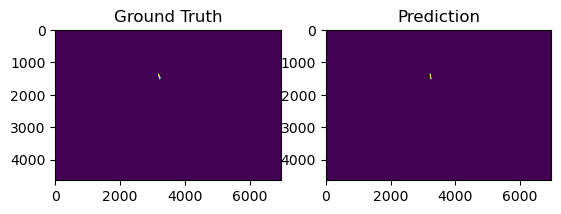


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5975.JPG
Prediction pixel count:  59604
Ground truth pixel count:  67156
IOU: 0.8455266797699643
Dice: 0.9162985168822972


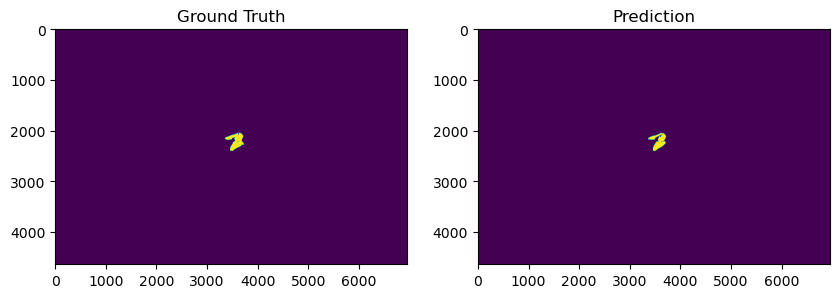


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5968.JPG
Prediction pixel count:  445836
Ground truth pixel count:  427078
IOU: 0.8422436644211451
Dice: 0.9143672801673475


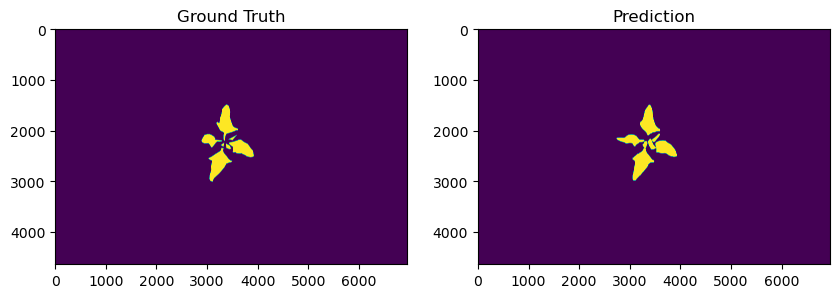


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5962.JPG
Prediction pixel count:  1951111
Ground truth pixel count:  1803784
IOU: 0.8595217107087675
Dice: 0.9244546119132493


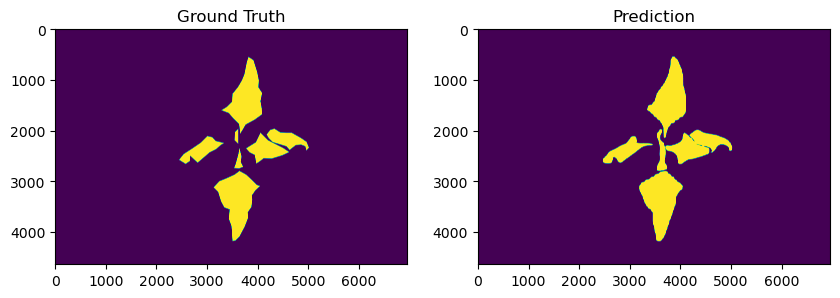


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5868.JPG
Prediction pixel count:  0
Ground truth pixel count:  4970
IOU: 0.0
Dice: 0.0


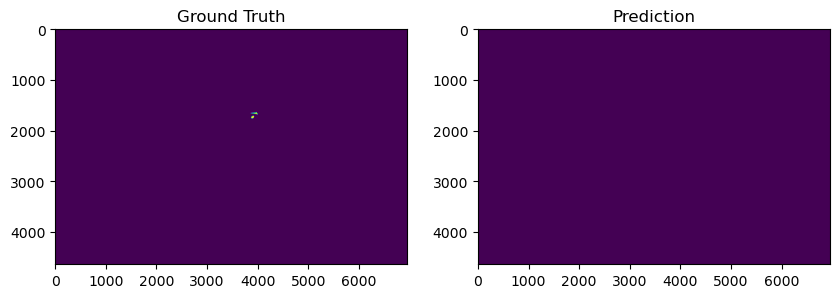


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5918.JPG
Prediction pixel count:  46242
Ground truth pixel count:  90526
IOU: 0.454174286564879
Dice: 0.6246490407112775


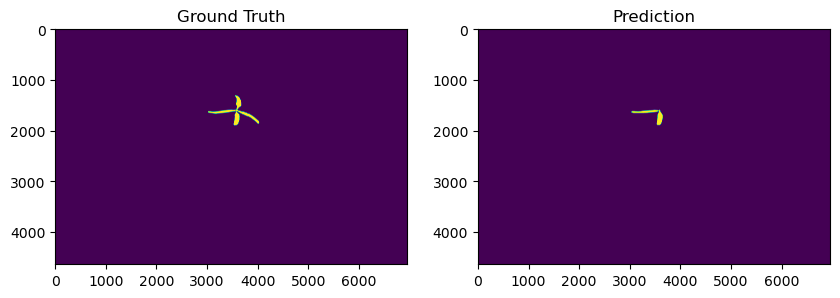


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5957.JPG
Prediction pixel count:  69492
Ground truth pixel count:  71893
IOU: 0.8589836302675695
Dice: 0.9241432966722071


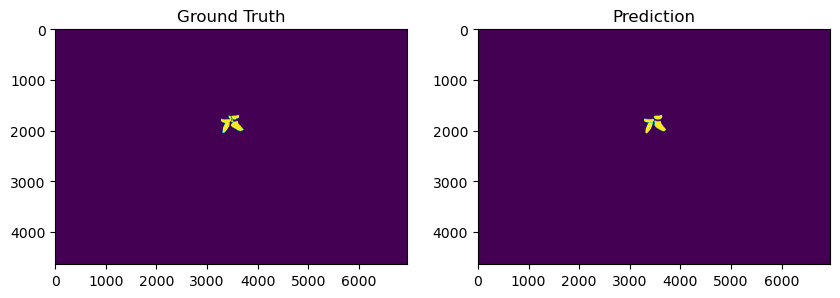


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5950.JPG
Prediction pixel count:  100517
Ground truth pixel count:  100562
IOU: 0.8943089430894309
Dice: 0.944206008583691


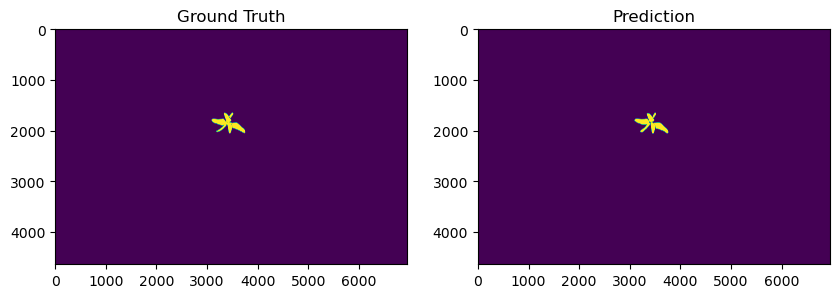


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6052.JPG
Prediction pixel count:  159095
Ground truth pixel count:  172114
IOU: 0.8474500638669337
Dice: 0.9174267607462357


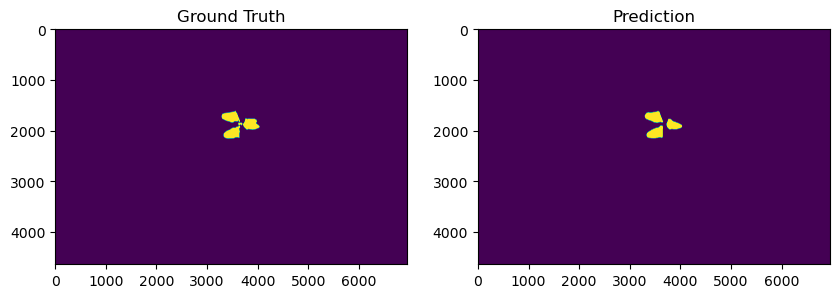


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6049.JPG
Prediction pixel count:  4766
Ground truth pixel count:  4847
IOU: 0.7586900841566044
Dice: 0.8627899719130344


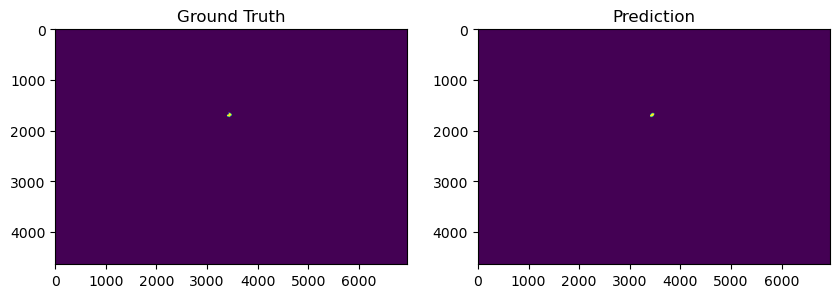


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6041.JPG
Prediction pixel count:  75926
Ground truth pixel count:  91640
IOU: 0.6268859589506592
Dice: 0.770657531957557


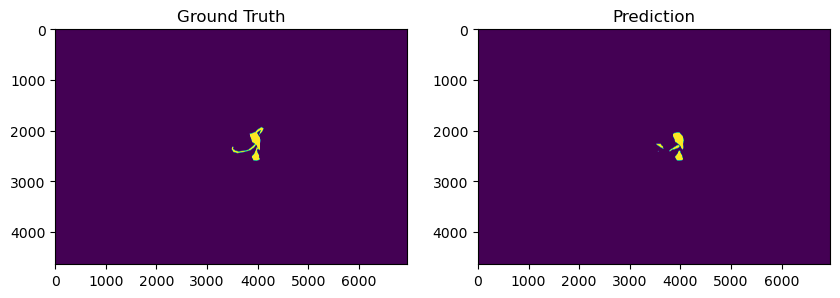


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6035.JPG
Prediction pixel count:  2275377
Ground truth pixel count:  2263824
IOU: 0.8873067093090119
Dice: 0.9402888305673179


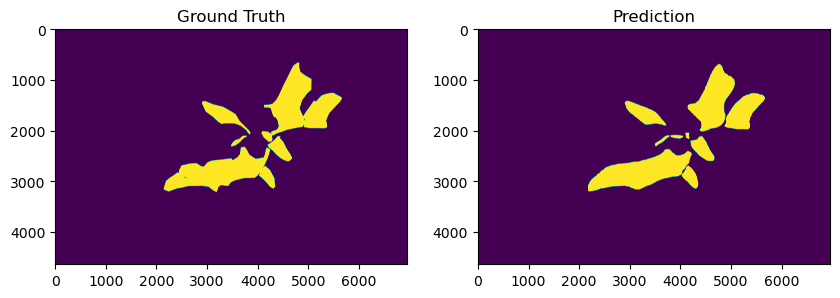


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6034.JPG
Prediction pixel count:  232995
Ground truth pixel count:  249294
IOU: 0.8912849109432719
Dice: 0.942517867917369


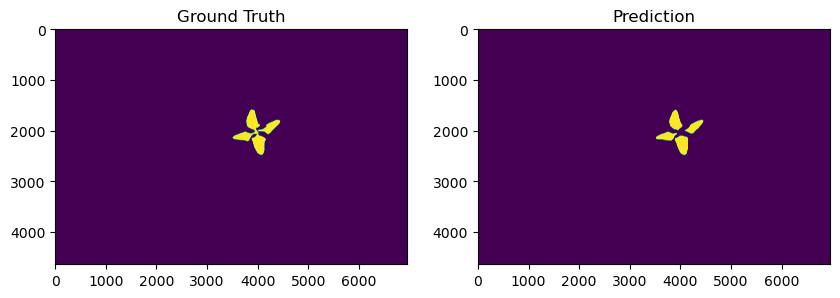


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6029.JPG
Prediction pixel count:  67880
Ground truth pixel count:  81687
IOU: 0.7455039854353636
Dice: 0.8541991214639593


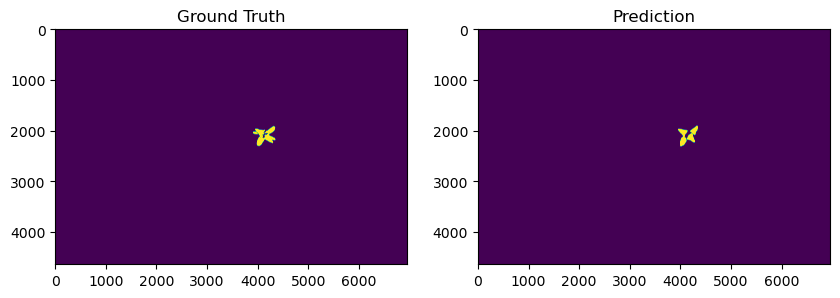


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5976.JPG
Prediction pixel count:  466975
Ground truth pixel count:  542192
IOU: 0.7303664203288696
Dice: 0.8441754437075331


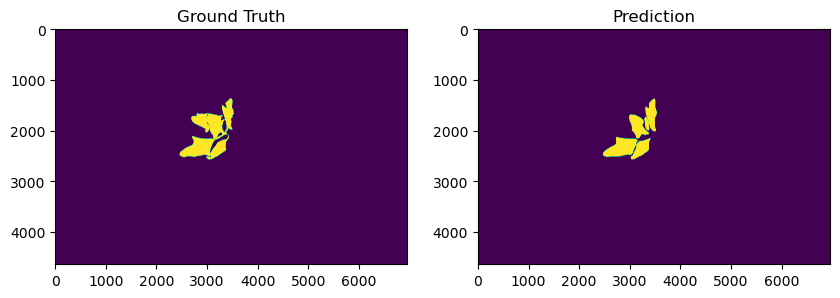


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5863.JPG
Prediction pixel count:  118860
Ground truth pixel count:  124999
IOU: 0.8616896204232449
Dice: 0.9257070684288872


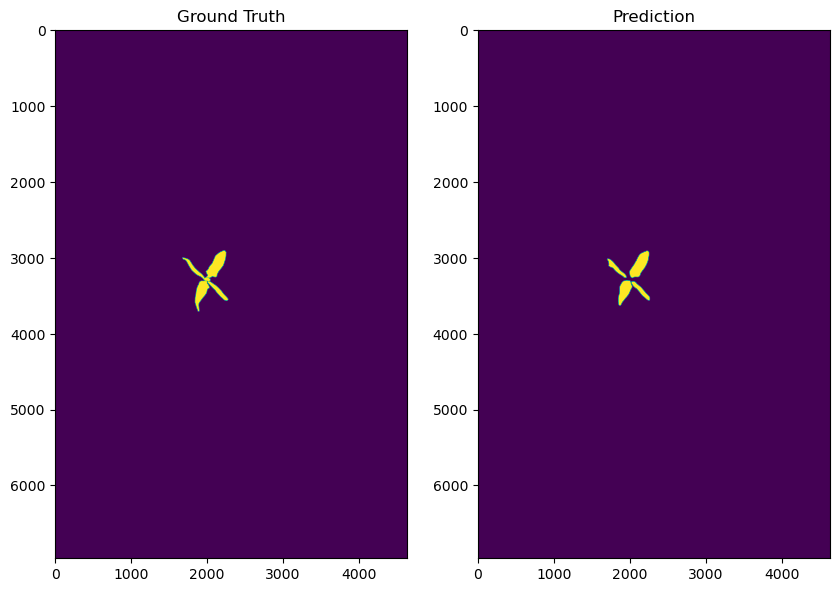


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5862.JPG
Prediction pixel count:  87111
Ground truth pixel count:  90713
IOU: 0.8544969130652428
Dice: 0.921540399496131


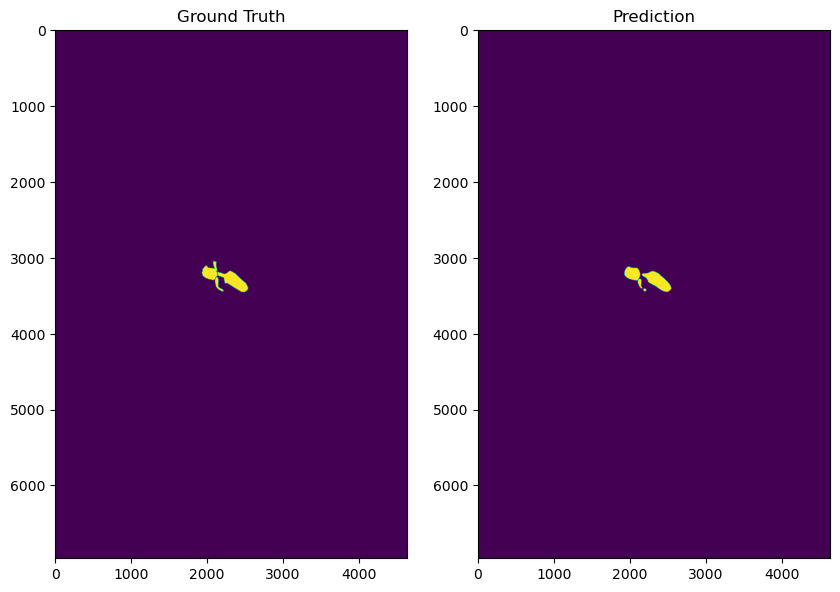


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5860.JPG
Prediction pixel count:  32445
Ground truth pixel count:  37801
IOU: 0.6663740955995731
Dice: 0.7997893118469379


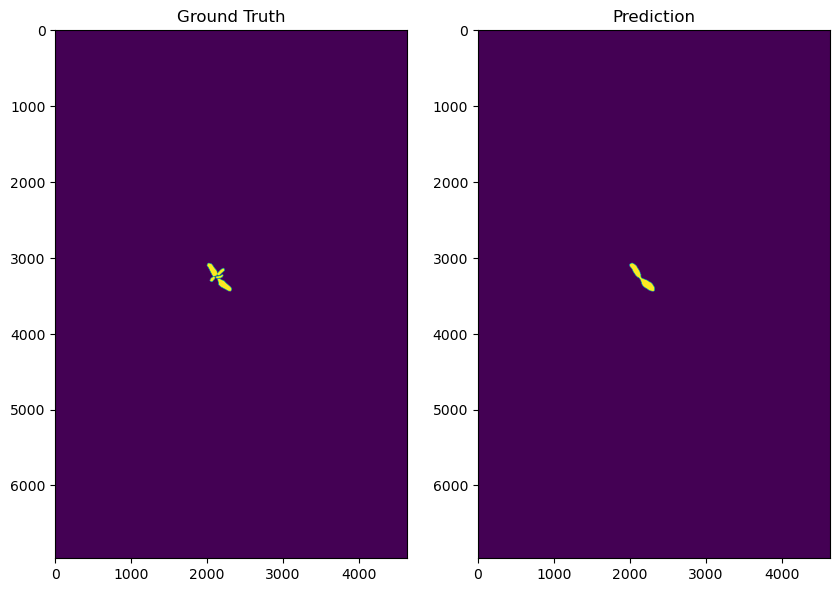


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5920.JPG
Prediction pixel count:  26065
Ground truth pixel count:  15125
IOU: 0.22443519619500593
Dice: 0.366593833454722


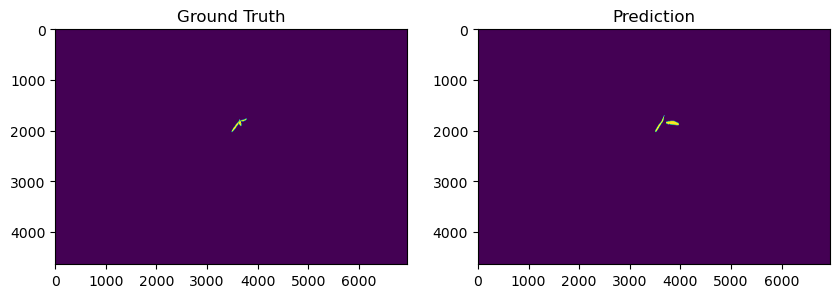


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5919.JPG
Prediction pixel count:  0
Ground truth pixel count:  0
IOU: None
Dice: None


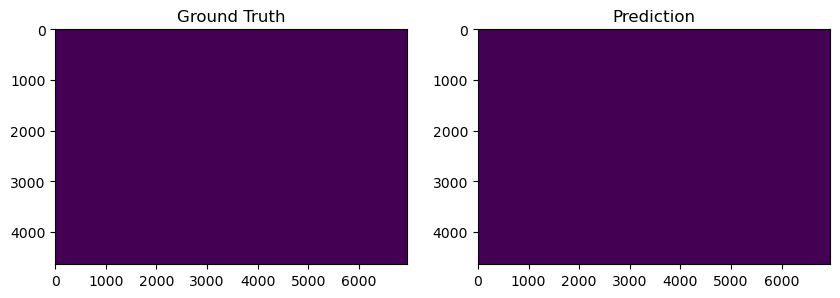


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6003.JPG
Prediction pixel count:  80961
Ground truth pixel count:  114829
IOU: 0.6075504540453552
Dice: 0.7558710863680475


/tmp/ipykernel_39954/5610809.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1, 2)


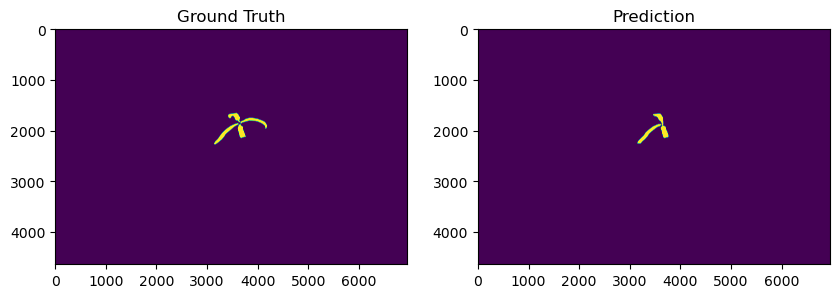


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6002.JPG
Prediction pixel count:  68142
Ground truth pixel count:  44370
IOU: 0.42868752539618044
Dice: 0.6001137656427759


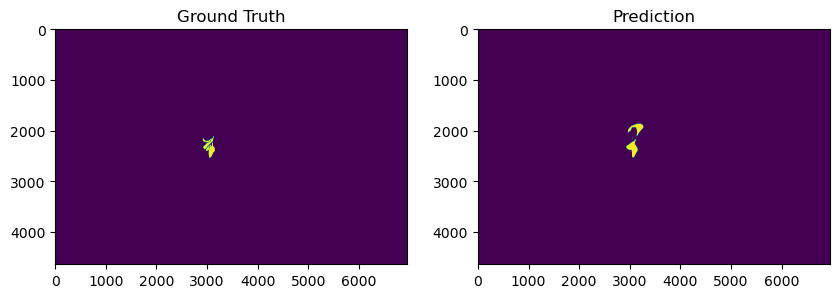


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6001.JPG
Prediction pixel count:  2127841
Ground truth pixel count:  2391372
IOU: 0.8160207351744507
Dice: 0.8986909888956329


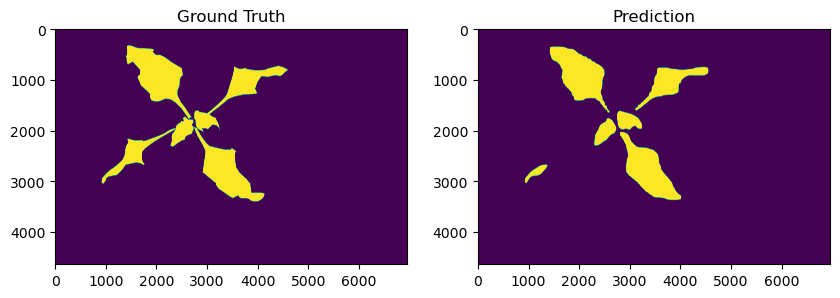


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5995.JPG
Prediction pixel count:  994247
Ground truth pixel count:  991200
IOU: 0.8971099712965476
Dice: 0.9457648579891581


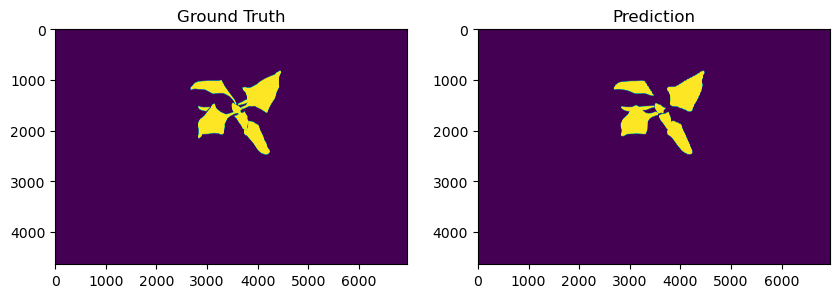


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5993.JPG
Prediction pixel count:  34467
Ground truth pixel count:  40468
IOU: 0.703300450061372
Dice: 0.8258090344965637


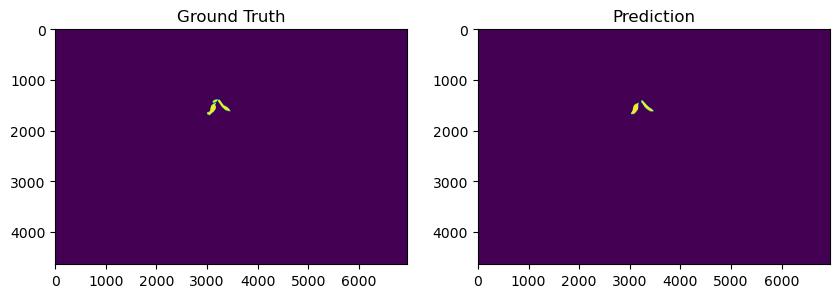


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5992.JPG
Prediction pixel count:  97877
Ground truth pixel count:  96413
IOU: 0.8650527002898996
Dice: 0.9276442431416954


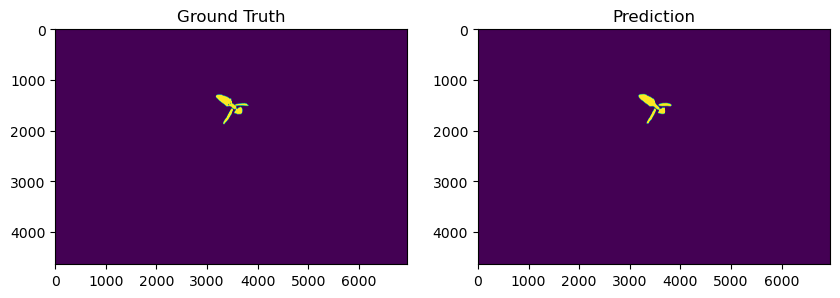


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5940.JPG
Prediction pixel count:  90097
Ground truth pixel count:  86221
IOU: 0.8107855521664561
Dice: 0.895506981703513


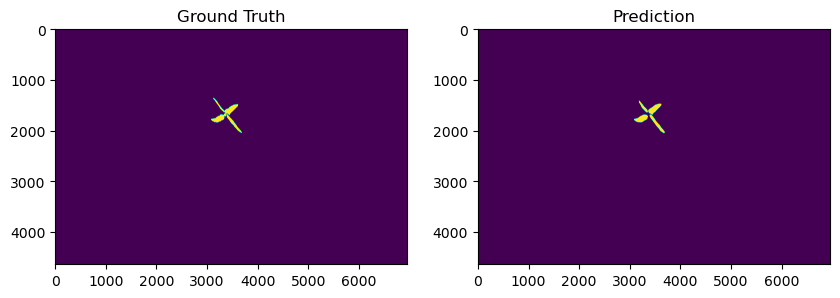


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5915.JPG
Prediction pixel count:  68084
Ground truth pixel count:  80339
IOU: 0.7610911377686019
Dice: 0.8643404324127663


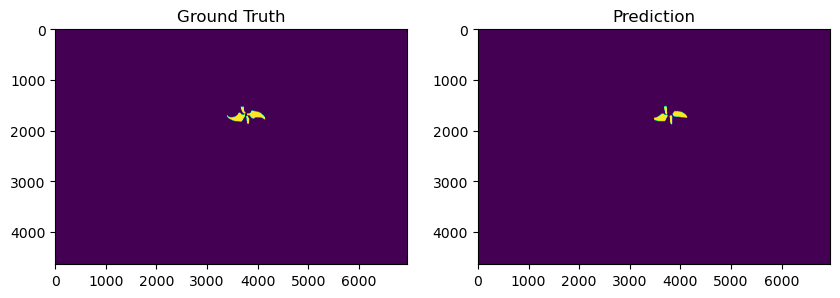


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5977.JPG
Prediction pixel count:  9198
Ground truth pixel count:  23853
IOU: 0.36568736829056653
Dice: 0.5355359898338931


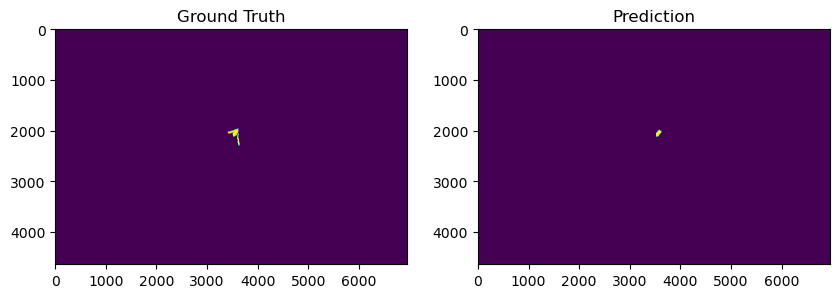


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5912.JPG
Prediction pixel count:  121494
Ground truth pixel count:  106576
IOU: 0.8008748934019772
Dice: 0.8894286841759109


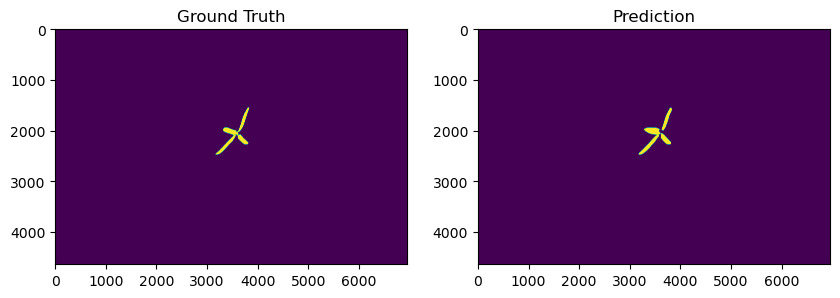


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5972.JPG
Prediction pixel count:  115110
Ground truth pixel count:  115926
IOU: 0.8678934092232068
Dice: 0.9292750913277584


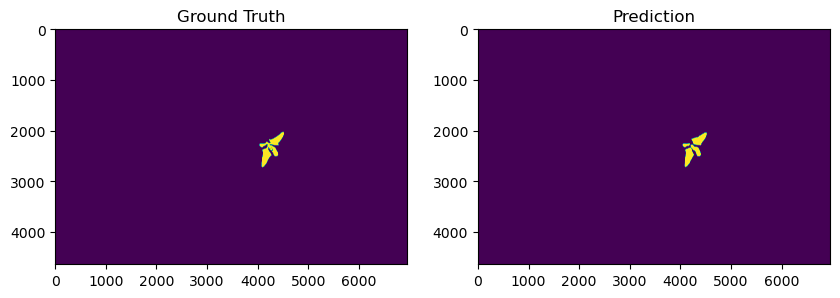


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5971.JPG
Prediction pixel count:  770729
Ground truth pixel count:  775604
IOU: 0.9068143451330598
Dice: 0.9511301899396831


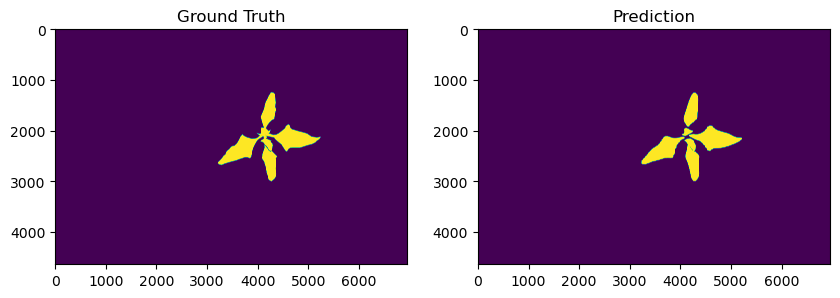


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5853.JPG
Prediction pixel count:  262059
Ground truth pixel count:  221155
IOU: 0.7449525315884313
Dice: 0.8538370163116135


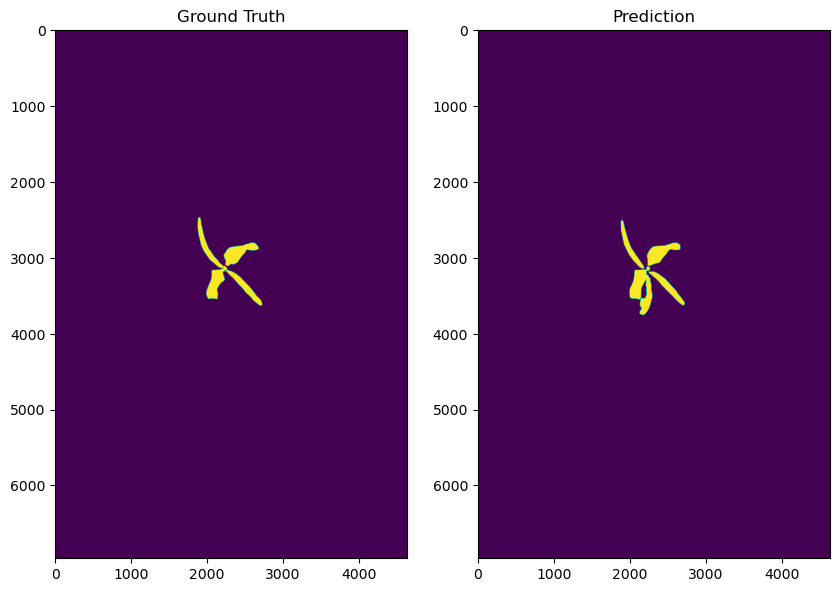


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5795.JPG
Prediction pixel count:  19434
Ground truth pixel count:  22142
IOU: 0.7035853308748208
Dice: 0.8260053877236867


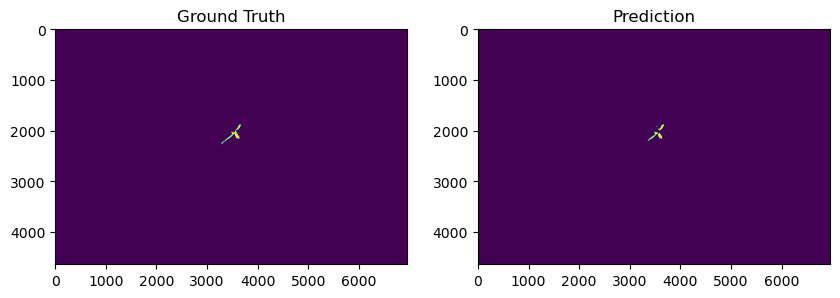


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5929.JPG
Prediction pixel count:  35924
Ground truth pixel count:  44413
IOU: 0.7787052207412656
Dice: 0.8755865914833763


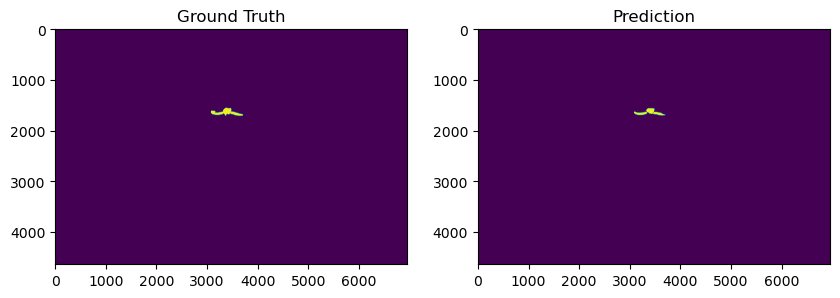

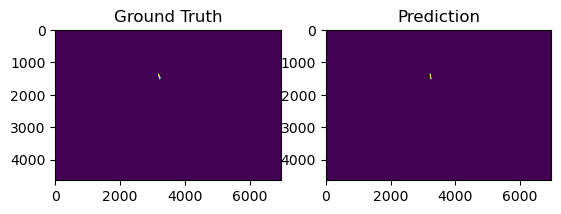

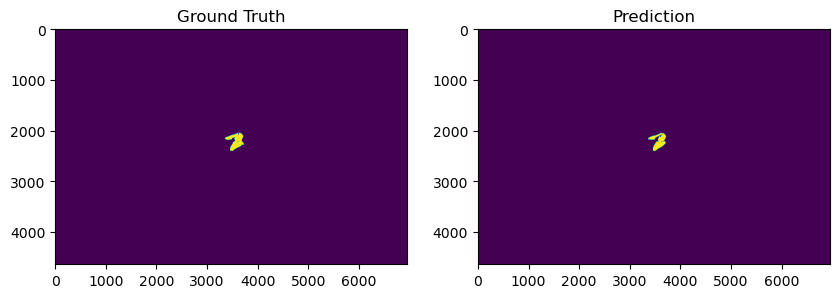

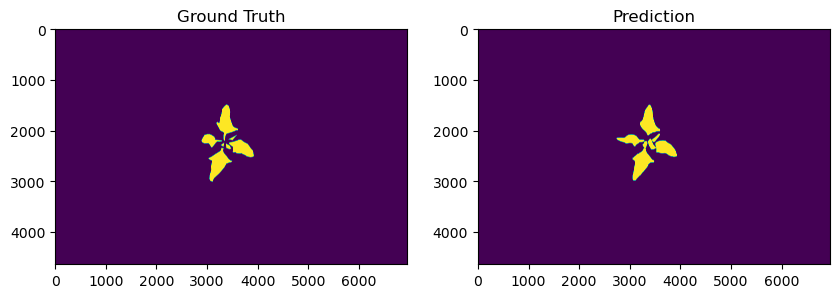

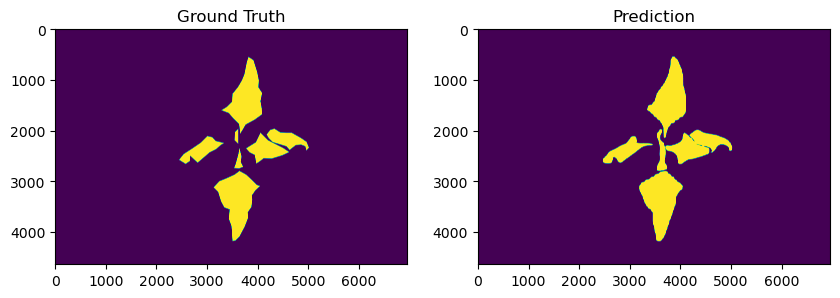

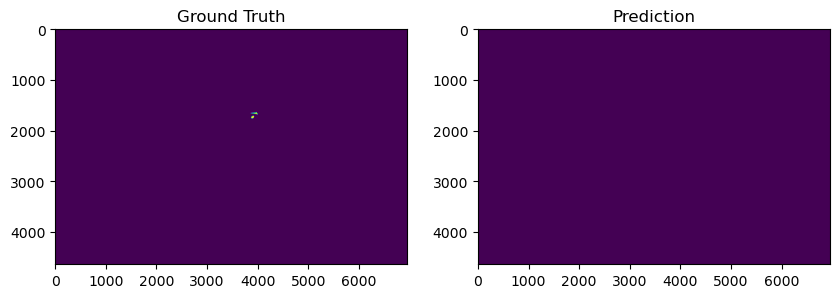

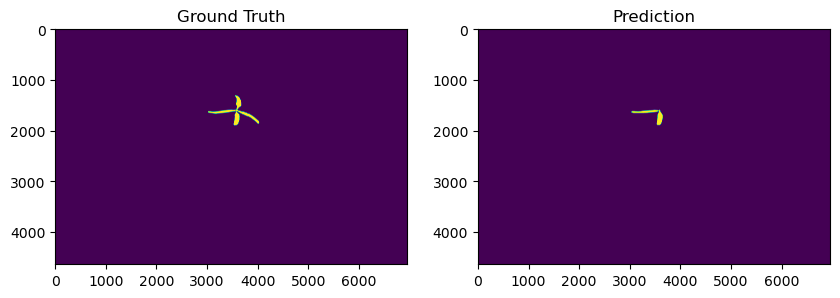

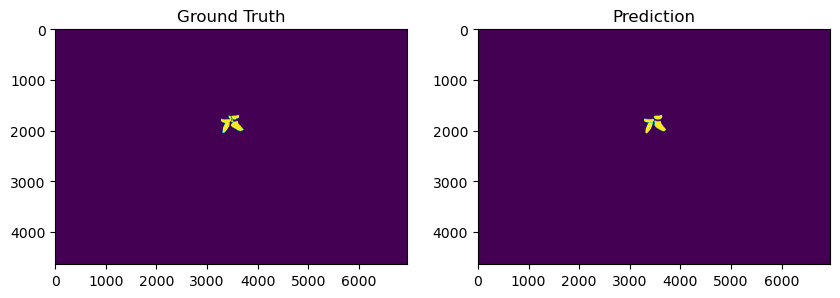

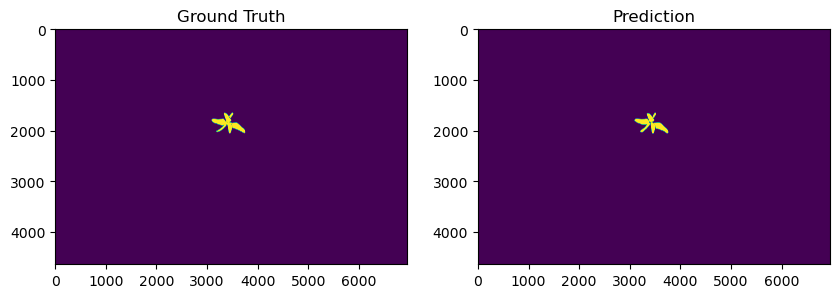

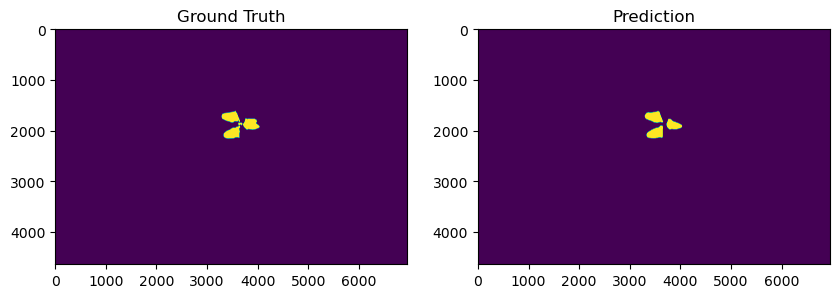

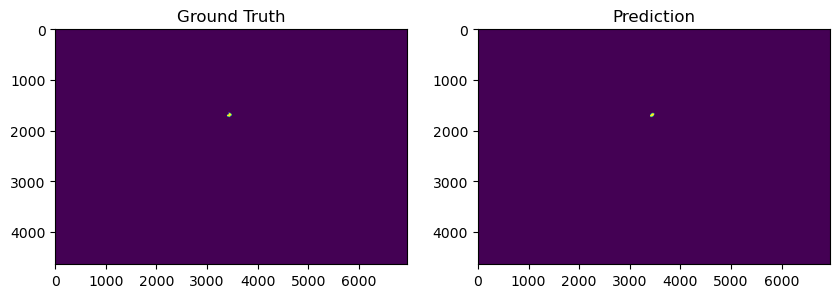

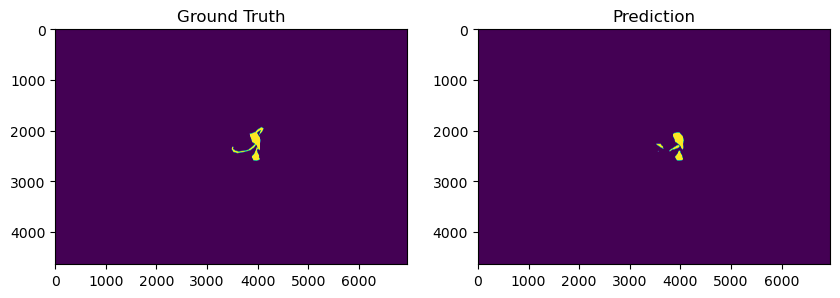

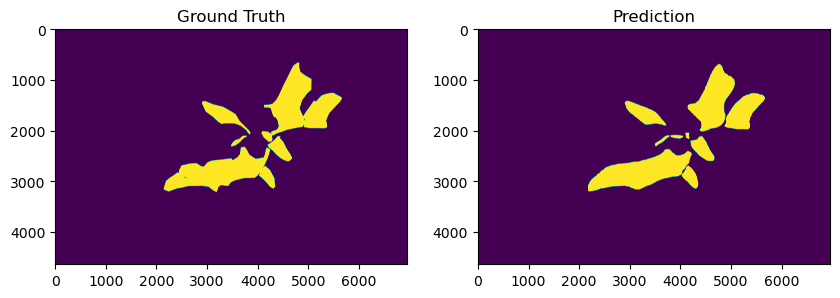

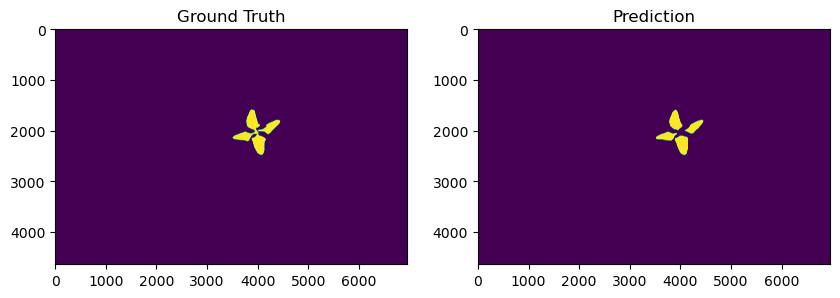

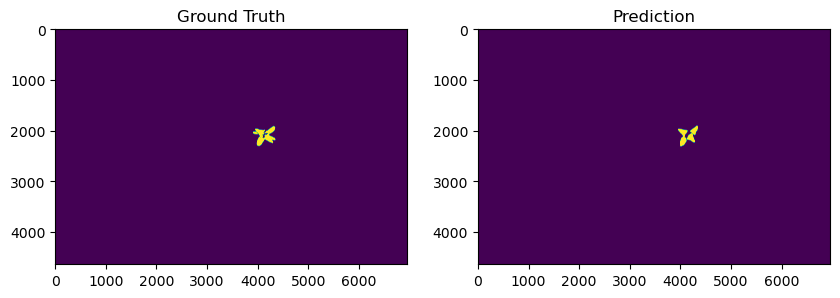

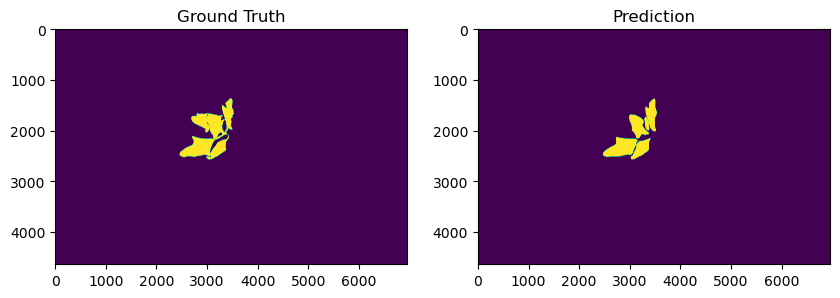

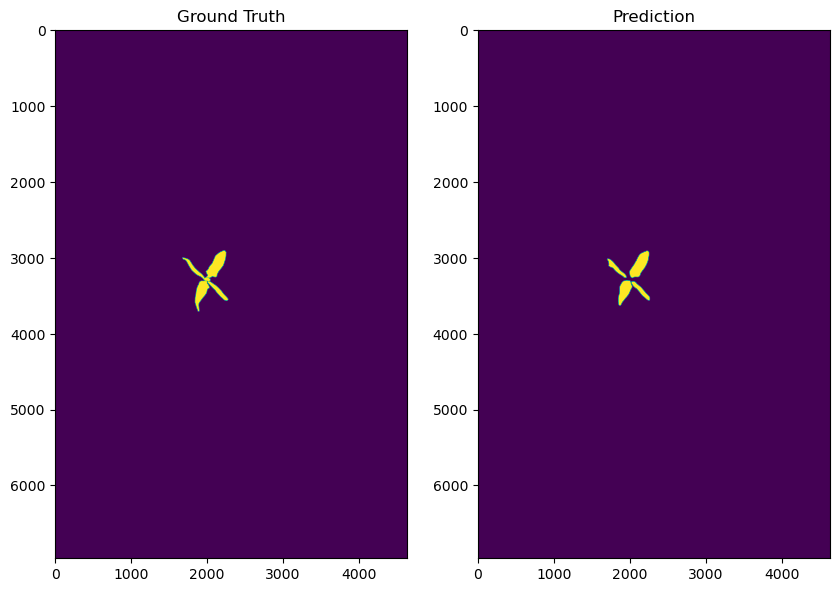

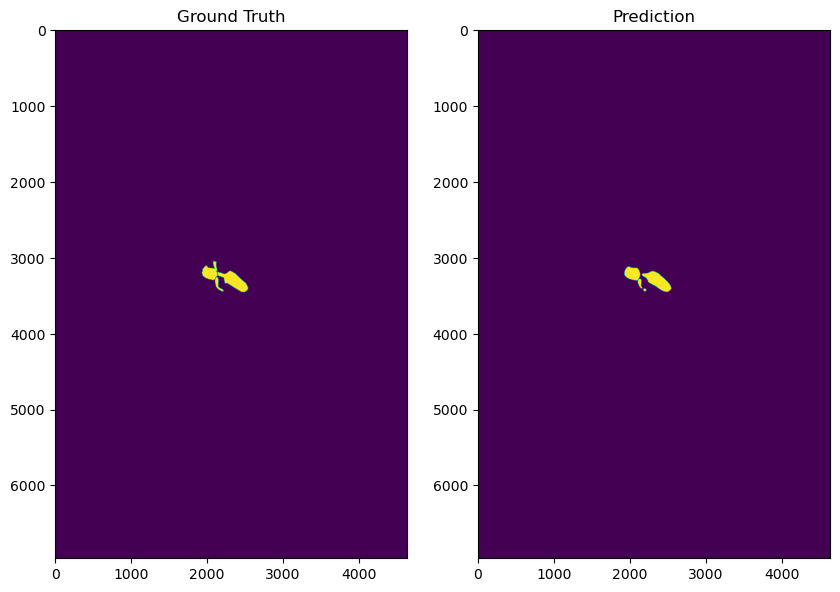

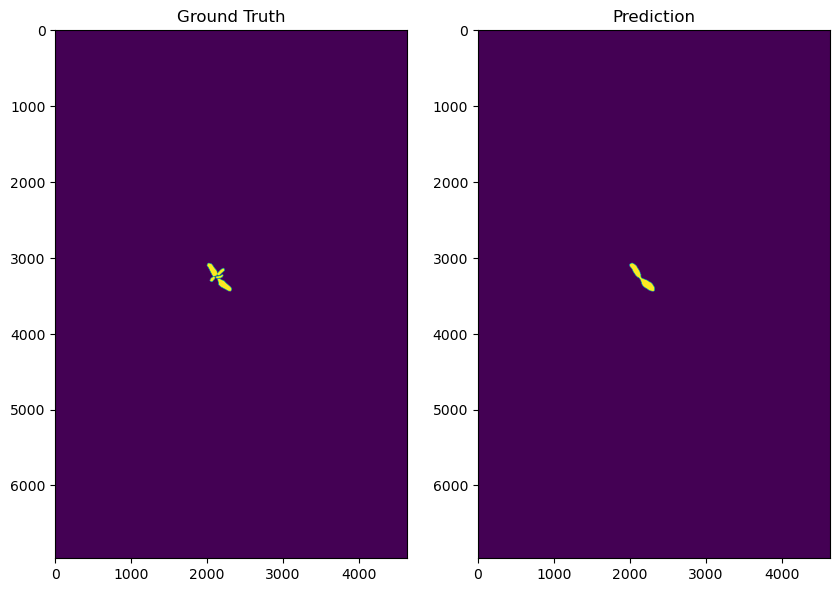

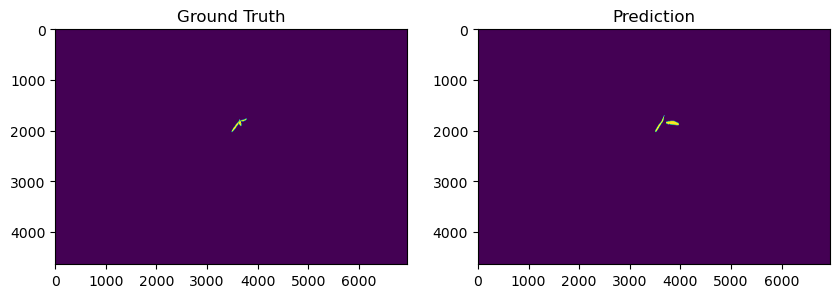

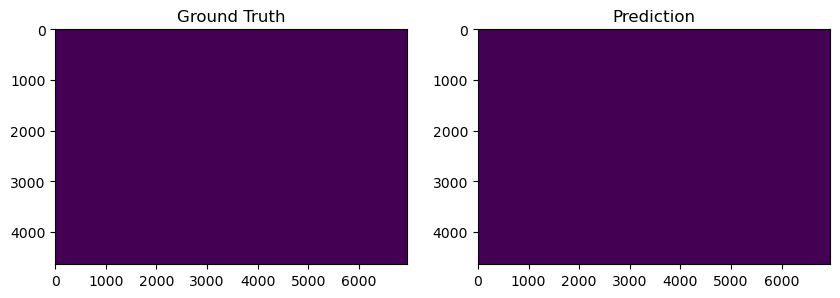

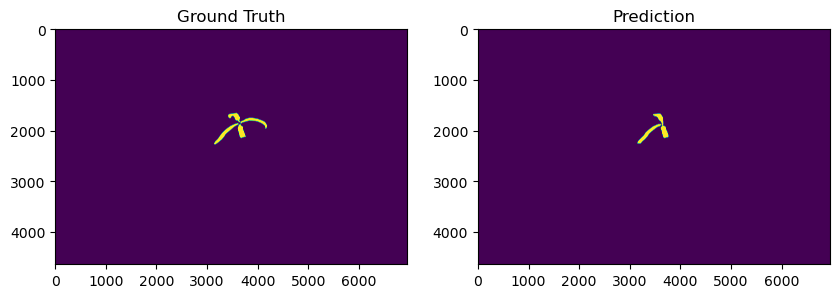

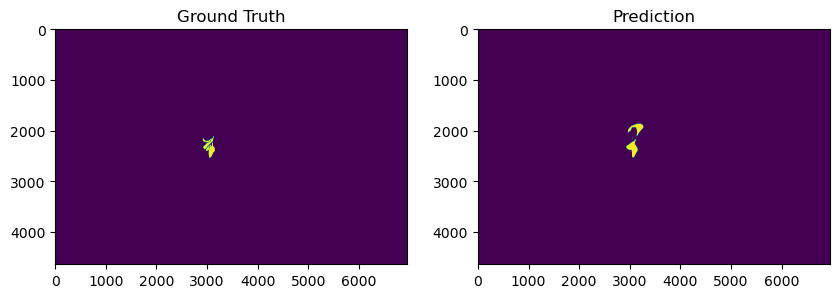

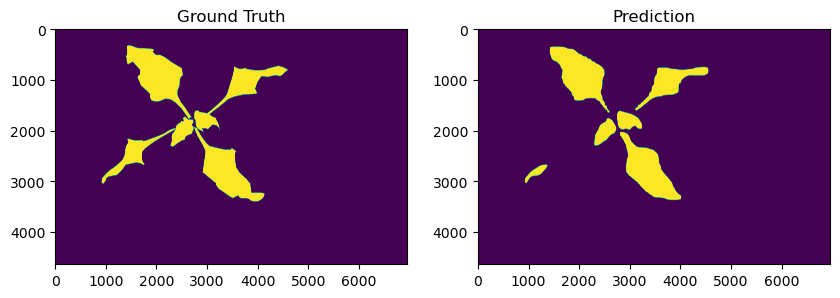

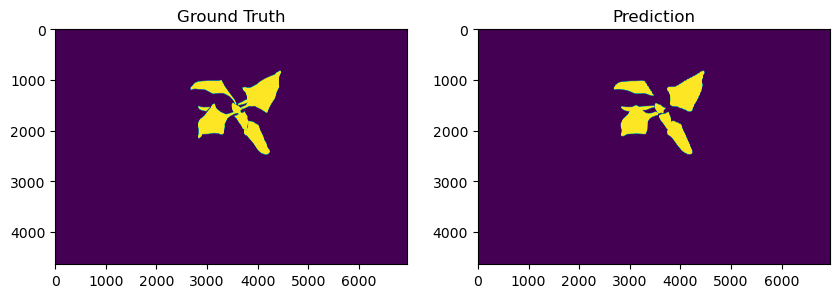

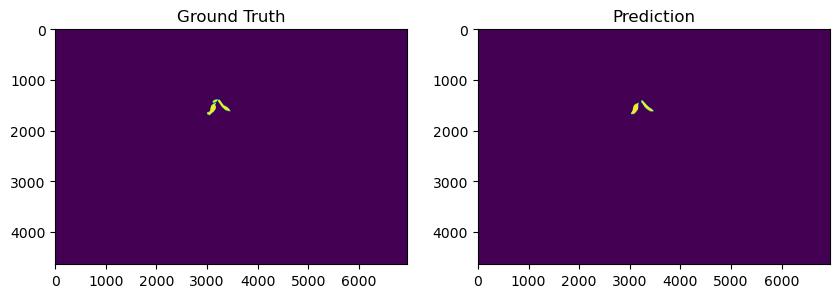

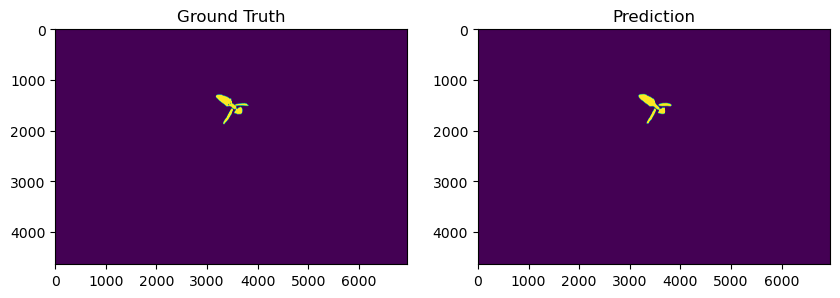

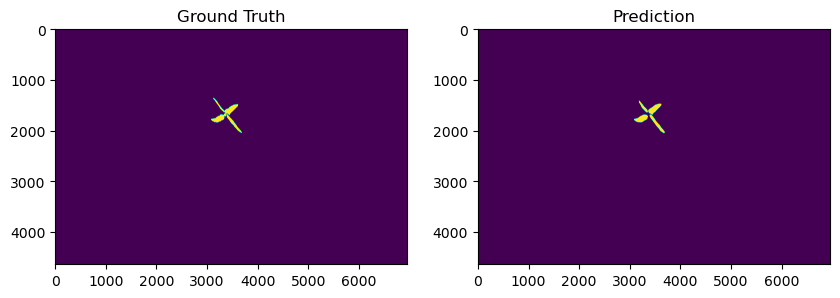

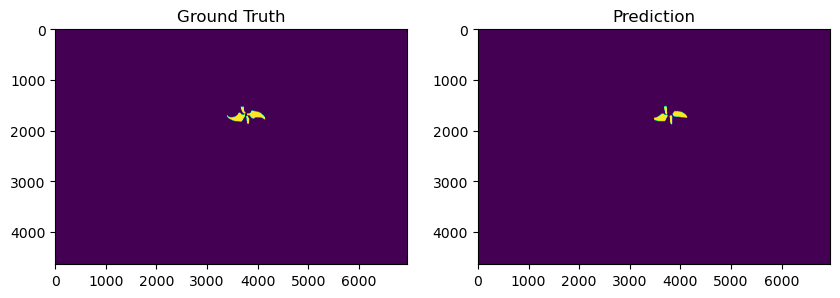

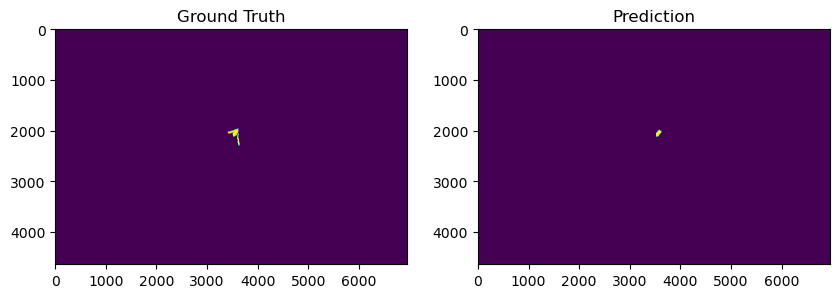

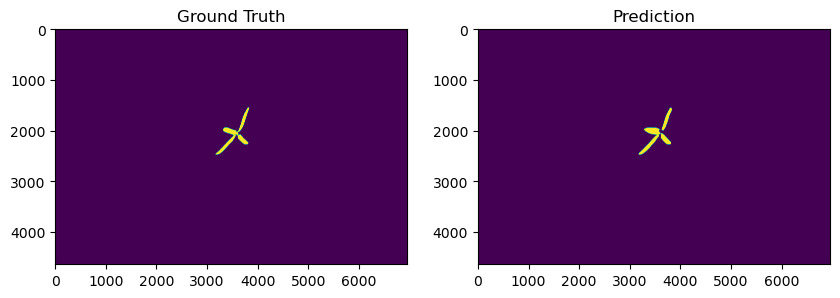

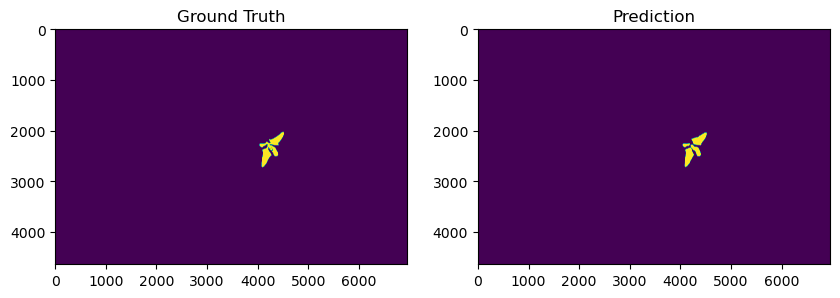

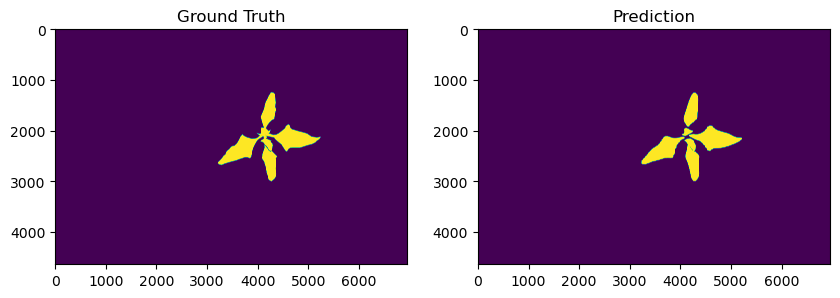

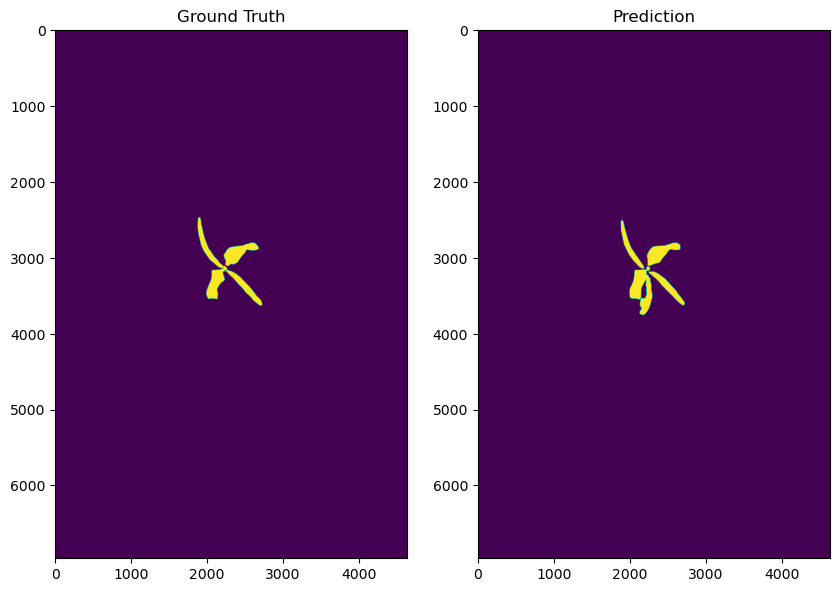

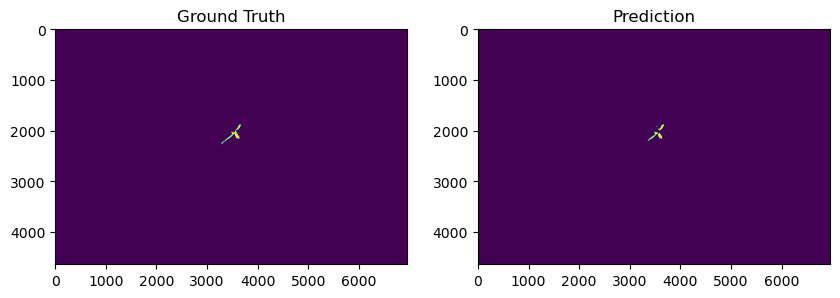

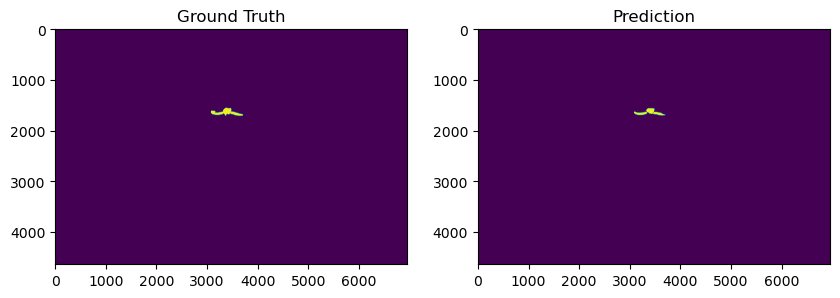

In [22]:
sample_ious = []
sample_dice = []

# sample = dataset.last()
for sample in dataset:
    
    print('\n --------------------------------------------------------------')
    print('\nSample: ', sample.filepath)

    # ------- get bboxes & masks for GROUND TRUTH and PREDICTIONS ------ #

    ground_truth_detections = sample.ground_truth.detections
    prediction_detections = sample.predictions.detections

    height = sample.height
    width  = sample.width

    ground_truth_bboxes = []
    ground_truth_masks = []

    prediction_bboxes = []
    prediction_masks = []
    detectron2_bboxes = []


    # get bboxes and masks from ground truth
    for d in ground_truth_detections:
        if (d.label == 'leaf'):
            ground_truth_bboxes.append(d.bounding_box)
            ground_truth_masks.append(d.mask)

    # get bboxes and masks from predictions
    for d in prediction_detections:
        if (d.label == 'leaf'):
            prediction_bboxes.append(d.bounding_box)
            prediction_masks.append(d.mask)
            detectron2_bboxes.append(d.original_bbox)



    # ---------- assemble PREDICTION mask for entire photo ------------ #
    complete_prediction_mask = np.zeros((height, width))


    for index, bbox in enumerate(prediction_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)], prediction_masks[index])

    print('Prediction pixel count: ', np.count_nonzero(complete_prediction_mask))



    # --------- assemble GROUND TRUTH mask for entire photo ----------- #
    complete_ground_truth_mask = np.zeros((height, width))

    for index, bbox in enumerate(ground_truth_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)], ground_truth_masks[index])

    print('Ground truth pixel count: ', np.count_nonzero(complete_ground_truth_mask))
    
    
     # ------- calculate Intersection Over Union (Jaccard Index) ------- #

    intersect = np.logical_and(complete_ground_truth_mask, complete_prediction_mask)
    union = np.logical_or(complete_ground_truth_mask, complete_prediction_mask)

    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    iou = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        iou = intersect_pixels / union_pixels

    print('IOU:', iou)
    sample_ious.append(iou)
    
    # ------------ calculate Dice Coefficient (F1 Score) -------------- #
    
    dice = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        dice = (2 * intersect_pixels) / (np.count_nonzero(complete_ground_truth_mask) + np.count_nonzero(complete_prediction_mask))

    print('Dice:', dice)
    sample_dice.append(dice)

    # --------- visualize GROUND TRUTH and PREDICTION masks ----------- #
    # if 'IMG_6153' in sample.filepath:
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')

    axarr[0].imshow(complete_ground_truth_mask)
    axarr[1].imshow(complete_prediction_mask)

    display(f)
 

In [23]:
print(sample_ious)

sample_ious = np.array(sample_ious, dtype=np.float)

print(sample_ious)

# sample_ious[sample_ious == None] = np.nan

print('Min IOU: ', np.nanmin(sample_ious))
print('Max IOU: ', np.nanmax(sample_ious))
print('Average IOU: ', np.nanmean(sample_ious))

print('\n')
# sample_dice[sample_dice == None] = np.nan

sample_dice = np.array(sample_dice, dtype=np.float)

print('Min Dice: ', np.nanmin(sample_dice))
print('Max Dice: ', np.nanmax(sample_dice))
print('Average Dice: ', np.nanmean(sample_dice))





[0.5888999667663676, 0.8455266797699643, 0.8422436644211451, 0.8595217107087675, 0.0, 0.454174286564879, 0.8589836302675695, 0.8943089430894309, 0.8474500638669337, 0.7586900841566044, 0.6268859589506592, 0.8873067093090119, 0.8912849109432719, 0.7455039854353636, 0.7303664203288696, 0.8616896204232449, 0.8544969130652428, 0.6663740955995731, 0.22443519619500593, None, 0.6075504540453552, 0.42868752539618044, 0.8160207351744507, 0.8971099712965476, 0.703300450061372, 0.8650527002898996, 0.8107855521664561, 0.7610911377686019, 0.36568736829056653, 0.8008748934019772, 0.8678934092232068, 0.9068143451330598, 0.7449525315884313, 0.7035853308748208, 0.7787052207412656]


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
total_dice = 0.7693692302489409 + 0.9192198343808647 + 0.8494511989802144 + 0.773003970816042 + 0.9131756362004316
avg_dice = total_dice / 5
print(avg_dice)

In [ ]:
total_r2 = 0.7996748496587117 + 0.9963375296453822 + 0.9725001037237607 + 0.9946219916894515 + 0.9971855695035271
avg_r2 = total_r2 / 5
print(avg_r2)